# Illustrate the Molecular Oncology Almanac
We wish to make a couple of figures that shows how the database breaks down by evidence category and by therapy type. We could put these two data types together but I think that it gets crowded.

In [28]:
import glob
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import sys

sys.path.append('../../../common/')
import settings
settings.set_arial_as_font()
colors = settings.Colors
tableau = colors.tableau10

%matplotlib inline

In [29]:
handles = glob.glob('/Users/brendan/Github/moalmanac-admin/database/almanac/*')
almanac = []

columns = ['disease', 'context', 'oncotree_term', 'oncotree_code', 
          'therapy_name', 'therapy_type', 
           'therapy_sensitivity', 'therapy_resistance', 'favorable_prognosis',
          'predictive_implication', 'description', 'source_type', 
           'citation', 'url', 'doi', 'pmid', 'nct', 'last_updated']

for handle in handles:
    dtype = handle.split('/')[-1].split('.tsv')[0]
    tmp = pd.read_csv(handle, sep='\t')
    tmp['dtype'] = dtype
    almanac.append(tmp.loc[:, columns])
    
almanac = pd.concat(almanac, ignore_index=True)

# Our database has a few items related to adverse event risk, but we focus on sensitivity, resistance, and prognosis
# for the paper
counts = almanac.loc[:, ['therapy_sensitivity', 'therapy_resistance', 'favorable_prognosis']].notnull().sum(axis=1)
almanac = almanac[~counts.eq(0)]

## Counts of sensitivity, resistance, and prognosis


In [30]:
for column in ['therapy_sensitivity', 'therapy_resistance', 'favorable_prognosis']:
    print(almanac[column].value_counts().sum())
    print()

434

104

184



## Predictive Implication

In [31]:
almanac['predictive_implication'].value_counts()

Clinical evidence    202
Guideline            151
Preclinical          121
Inferential          115
FDA-Approved          87
Clinical trial        46
Name: predictive_implication, dtype: int64

In [32]:
order = ['FDA-Approved', 'Guideline', 'Clinical trial', 'Clinical evidence', 'Preclinical', 'Inferential']
values = almanac['predictive_implication'].value_counts()
values = values.loc[order]

values.rename(index={'FDA-Approved': 'FDA'}, inplace=True)

evidence = values.copy(deep=True)
n = almanac.shape[0]

In [33]:
n

722

## Therapy type

In [34]:
almanac['therapy_type_short'] = almanac['therapy_type'].str.split(' ', expand=True).loc[:, 0]
values = almanac['therapy_type_short'].value_counts()

order = ['Targeted', 'Immunotherapy', 'Chemotherapy', 'Radiation', 'Hormone', 'Combination']
values = values.loc[order]
therapy_types = values.copy(deep=True)

sum_types = therapy_types.sum()

## Side-by-side figure
We plot the predictive implication and therapy types side by side

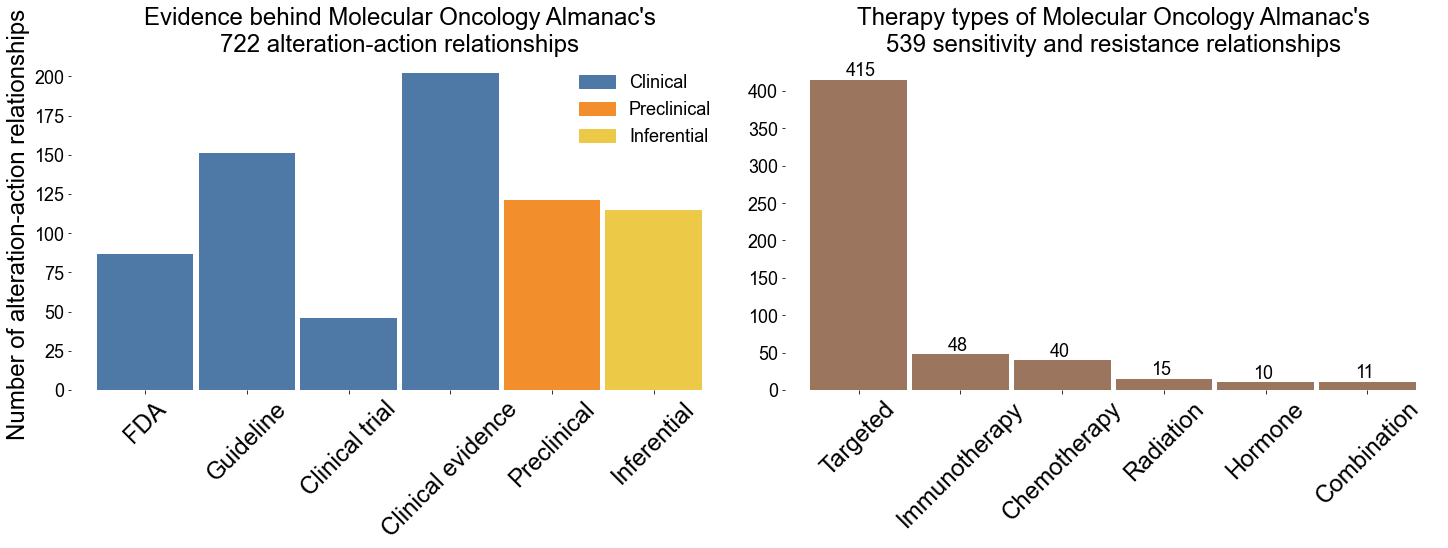

In [35]:
size_title = 24
size_ylabel = 24
size_xlabel = 24
size_yticks = 18
size_legend = 18

fig = plt.figure(constrained_layout = True, figsize=(20, 7.5))

gs = GridSpec(1,2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
p1 = evidence.plot.bar(width=0.95, 
                       color=[tableau['blue'], tableau['blue'], tableau['blue'], 
                              tableau['blue'], tableau['orange'], tableau['yellow']], 
                       ax=ax1)
title = "Evidence behind Molecular Oncology Almanac's\n{} alteration-action relationships".format(n)
ylabel = "Number of alteration-action relationships"

clinical = patches.Patch(color=tableau['blue'], label='Clinical')
preclinical = patches.Patch(color=tableau['orange'], label='Preclinical')
inferential = patches.Patch(color=tableau['yellow'], label='Inferential')

plt.legend(handles=[clinical, preclinical, inferential], loc=1, fontsize=size_legend, frameon=False)

plt.title(title, fontsize=size_title)
plt.ylabel(ylabel, fontsize=size_ylabel)
plt.xticks(fontsize=size_xlabel, rotation=45)
plt.yticks(fontsize=size_yticks)

ax2 = fig.add_subplot(gs[0, 1])
p2 = therapy_types.plot.bar(width=0.95, color=[tableau['brown']], ax=ax2)

title = "Therapy types of Molecular Oncology Almanac's\n{} sensitivity and resistance relationships".format(sum_types)
ylabel = "Number of alteration-action relationships"

plt.title(title, fontsize=size_title)
# plt.ylabel(ylabel, fontsize=size_ylabel) # Hiding ylabel since it is the same as the left figure
plt.xticks(fontsize=size_xlabel, rotation=45)
plt.yticks(fontsize=size_yticks)
plt.ylim([0, 445])

for patch in ax2.patches:
    x = patch.get_x()
    height = patch.get_height()
    ax2.text(x+0.35, 
             height+5,
            '{}'.format(round(height)), 
             color='k',
             fontsize=size_yticks
            )

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)

filename = 'molecular-oncology-almanac-breakdown'
for suffix in ['svg', 'png']:
    outname = '../../../figures/{}.{}'.format(filename, suffix)
    plt.savefig(outname, format=suffix)
plt.show()